# Design Thinking Project Tasks
The World Health Organization (WHO) is interested in projecting the death rate of COVID-19 in various countries so that they are able to coordinate help and support to countries affected by COVID-19. Different countries have different health care systems, population densities, and national policies in combating COVID-19. You are to help WHO to make a model to predict the number of deaths based on known data of each particular country. One of the challenges is to find some appropriate predictor variables for the model.

## Students Submission
#### Student's Name:
- Vernon (1005143)
- Chuan Shao (1005549)
- Darius (1005451)
- Jun Jie (1005017)
- Zhuo Xuan (1005304)

## **Task 1**: Build a Multiple Linear Regression model that predicts the number of deaths in various countries due to COVID-19. You are free to select and choose the dataset you would like to use while building the model and are allowed to use the Pandas Library in your code and can use Excel.
The following technical/tool constraint applies: you are NOT allowed to use any existing machine learning packages, such as scikit-learn.
As a general guide, you may need to undertake the following actions:
- Find data sets for the number of deaths in various countries (a minimum of 20 countries)
due to COVID-19.
- Research for appropriate predictor variables to predict deaths due to COVID-19.
- You may use time as one of the predictors (in which case you could attempt to predict
death rates in the future), or you may choose to leave it out (in which case, you would
be looking at the deaths at a fixed chosen point in time).
- Find data sets on the chosen predictors for the various countries in the model.
- Use plots to visualize and understand your data.
- Build a model and test the accuracy of your model, using an appropriately chosen metric
(hint: r2 is not a good metric for this task).
- If needed, improve your model by incorporating other predictors, and/or removing
existing ones.
- Discuss your data sets, model, accuracy, and what metrics you used to judge the
accuracy.

### Quick access to each section for task 1

- [Introduction](#Introduction)
- [Analyzing Predictor Variables](#Analyzing-potential-predictor-variables)
- [Finding and reading data set](#Finding-and-reading-data-set)
- [Preliminary cleaning up of data set](#Preliminary-cleaning-up-of-data-set)
- [Visualizing relationship](#Visualizing-relationship)
- [Extracting predictor variables](#Extracting-predictor-variables-&-Cleaning-up-data-set)
- [MLR iteration 1](#MLR-Iteration-1:)
- [MLR iteration 2](#MLR-Iteration-2:)
- [MLR iteration 3](#MLR-Iteration-3:)
- [Conclusion](#Conclusion)
- [References](#References)

### Requirements
Import the below packages. If an error of "module not found" is shown, use the following commands in your command prompt or Windows Powershell.

- pip install numpy
- pip install pandas
- pip install matplotlib.pyplot
- pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Defining functions to simplify procedure for Multiple Linear Regression (MLR)

The below functions are to define the procedure to compress the Multiple Linear Regression model into a single function and to plot all graphs according to the list of independent and dependent variables. The code are adapted from Data Driven World problem sets with some alterations. Comments are written to give a basic understand of what each function does.

In [3]:
# Define a function such that it is reusable easily
def linear_regression(df_independent, df_dependent, independent_column, dependent_column):
    # Normalize the independents using z normalization
    df_independent = normalize_z(df_independent)

    # Change the independents and the dependent to numpy array using the prepare functions
    X = prepare_independent(df_independent)
    dependent = prepare_dependent(df_dependent)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((len(independent_column) + 1, 1))
    
    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, dependent, beta, alpha, iterations)

    # call the predict() method
    pred = predict(df_independent, beta)
    
    # Print all of the betas with labels at the side
    for idx in range(len(beta)):
        if idx == 0:
            print("Constant: " + str(beta[idx]))
        else:
            print(independent_column[idx - 1] + ": " + str(beta[idx]))
    print("\n") 

    # change dependent test set to a numpy array
    dependent = prepare_dependent(df_dependent)

    # Calculate r2 score
    r2 = r2_score(dependent, pred)   
    print("r2:", r2)
    
    # Calculate r2_adjusted score
    r2_adj = r2_adjusted(dependent, pred, beta)
    print("r2_adj:", r2_adj)

    # Calculate the RMSE and the mean to compare the data
    rmse = root_mean_squared_error(dependent, pred)

    print("RMSE:", rmse)
    print("Mean:", float(df_dependent.mean()))
    
    print("Relative RMSE:", (rmse / float(df_dependent.mean())))
    
    # Check and verify that the cost function decreases and optimal beta is found
    plt.title(f"Cost function over {iterations} iterations")
    plt.plot(J_storage)
    
    return beta, pred

# Plot all of the relationship with respect to the dependent for visualization
def plot_relationship(df_independent, df_dependent, pred, independent_column, dependent_column):
    for idx in range(len(independent_column)):
        plt.figure(idx)
        plt.scatter(df_independent[independent_column[idx]], df_dependent, label="Actual")
        plt.scatter(df_independent[independent_column[idx]], pred, label="Predicted")
        plt.xlabel(independent_column[idx])
        plt.ylabel(dependent_column[0])
        plt.title(independent_column[idx])
        plt.legend()
        
# Apply Z-normalization on the data to change the data into a standard normal distribution
def normalize_z(df):    
    return (df - df.mean()) / df.std()

# Scale all data from 0 to 1
def normalize_minmax(dfin):
    df_max =  dfin.max(axis = 0)
    df_min = dfin.min(axis = 0)
    dfout = (dfin - df_min) / (df_max - df_min)
    return dfout

# To split the DataFrame into its dependent and independent variables according to the country specified
def get_independents_dependents(df, independent_names, dependent_names):
    df_independent = df.loc[: , independent_names]
    df_dependent = df.loc[: , dependent_names]
    return df_independent, df_dependent

# Add a 1 column on the left of the dataframe for constant and add change the dataframe into a numpy array
def prepare_independent(df_independent):
    left = np.ones((len(df_independent), 1))
    np_independent = df_independent.to_numpy()
    
    # axis = 1 indicates to move it along the x axis or in the way of the columns
    return np.concatenate((left, np_independent), axis=1)

# Change dataframe into a numpy array
def prepare_dependent(df_dependent):
    return df_dependent.to_numpy()

# Calculate and get predicted values
def predict(df_independent, beta):
    df_independent = normalize_z(df_independent)
    df_independent = prepare_independent(df_independent)
    return np.matmul(df_independent, beta)

# Split the input data into training dataset and testing datasets
def split_data(df_independent, df_dependent, random_state=None, test_size=0.5):
    np.random.seed(random_state)

    test_length = int(len(df_independent) * test_size)
    independent = np.random.choice(len(df_independent), len(df_independent), replace=False)
    
    df_independent_test = df_independent.loc[independent[:test_length], :]
    df_independent_train = df_independent.loc[independent[test_length:], :]    
    df_dependent_test = df_dependent.loc[independent[:test_length], :]
    df_dependent_train = df_dependent.loc[independent[test_length:], :]
    
    return df_independent_train, df_independent_test, df_dependent_train, df_dependent_test
  
# Calculate the r2 score to see the fit of the model
def r2_score(y, ypred):
    if type(y) == pd.DataFrame:
        y = y.to_numpy()
        
    if type(ypred) == pd.DataFrame:
        ypred = ypred.to_numpy()
        
    ymean = np.mean(y)
    ss_res = np.sum(np.matmul((y - ypred).T, (y - ypred)))
    ss_tot = np.sum(np.matmul((y - ymean).T, (y - ymean)))
    
    return 1 - (ss_res / ss_tot)
    pass

# r2 adjusted is to take into account the number of variables used in retrospect with the number of data points
def r2_adjusted(dependent, pred, beta):
    r2 = r2_score(dependent, pred)
    n = dependent.shape[0]
    k = beta.shape[0]
    r2_adj = 1 - (((1 - r2) * (n - 1)) / (n - k - 1))
    return r2_adj

# Calculate the mean squared error
def root_mean_squared_error(dependent, pred):
    if type(dependent) == pd.DataFrame:
        dependent = dependent.to_numpy()
        
    if type(pred) == pd.DataFrame:
        pred = pred.to_numpy()
        
    ss_res = np.sum(np.matmul((dependent - pred).T, (dependent - pred)))
    
    mse = 1 / len(dependent) * ss_res
    return math.sqrt(mse)
    pass

# Used to calculate cost function
def compute_cost(X, y, beta):
    inner = np.matmul(X, beta) - y
    J = (1 / (2 * len(X))) * np.matmul(inner.T, inner)
    J = J[0][0]
    return J

# Using gradient descent to optimize the beta found
def gradient_descent(X, y, beta, alpha, num_iters = 1500):
    J_storage = compute_cost(X, y, beta)
    
    for _ in range(num_iters):
        beta = beta - alpha / len(y) * np.matmul(X.T, np.matmul(X, beta) - y)
        J_storage = np.append(J_storage, compute_cost(X, y, beta))
        
    return beta, J_storage

# Introduction

Almost two years have passed since the beginning of the COVID-19 pandemic, and the whole world is still grappling with the disruption that the appearance of the SARS-Cov-2 virus has brought us. This pandemic's effects can be felt very strongly in the exceptional death toll that it has left us with. 

In this study, we will analyze and discuss the impact of several factors affecting the **absolute number of deaths** due to COVID-19. As part of the study, we will build a Multiple Linear Regression (MLR) model that predicts the number of deaths based on some known data of a country.

## Analyzing potential predictor variables

To begin, we start with online research to determine useful predictors that we would like to include in our model. These useful predictors are merely just guides and does not have to be used extensively. 

- **Number of cases**
    - The first intuitive and straightfoward predictor would be the number of cases. As can be seen, with a large amount of cases, can there be a large amount of deaths. Therefore, one of the predictor that we would like is the number of cases.
    
    
- **Health of the people & Age**
    - Based on a study by a group of researchers in Rio de Janerio, it is suggested that an individual's immunity affects the susceptibility to suffer more severe form of infection. It is also found that older people have lower immunity, thus, mortality and lethality increases with age. [[1]](#References)
    
    
- **Skin colour & Gender**
    - Based on the study in Rio de Janerio, skin colour and gender have also been found to be associated with the probability of death. [[1]](#References)
    
    
- **Vaccination Status**
    - Based on a study by the Centers of Disease Control and Prevention (CDC), an individual that has been vaccinated has lower mortality rate. [[2]](#References)
    
    
- **Population, Income, Occupation, & Transport**
    - Based on a study in the United States, it is suggested that the population, income, occupation, and transport have a high association with the spread of the virus. With higher spread of virus, there would be more cases, thus we can also infer that there would be more deaths. [[3]](#References)
    
    
- **Healthcare Systems & Policies**
    - Based on a study in the European Union, a variable found to greatly influence the COVID-19 mortality rate depends on the healthcare system a country has, as well as the policies that they possess. [[4]](#References)

## Finding and reading data set

Through online searches, a comprehensive data set has been found from https://ourworldindata.org/covid-deaths. [[5]](#References)

To begin, we can firstly look at the dataset that we have found and search through the columns and countries that it contains and identify the information that we want. Furthermore, we would also like to verify that the number of countries is more than 20.

In [4]:
# Read the CSV file
owid_csv = pd.read_csv("covid-data.csv")

print("Dataset shape:", owid_csv.shape)
print("Number of locations:", len(pd.unique(owid_csv["location"])), "\n")

print(owid_csv.columns, "\n")

print(owid_csv["location"].unique(), "\n")

Dataset shape: (126246, 65)
Number of locations: 233 

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'ne

## Understanding our data set

### Preliminary cleaning up of data set

Analzying the variables and input of the data above, we can identify outliers such as "World", "Asia", etc, under location. Further analyzing the excel file, it is seen that these information are the sum of all countries in a region and thus we would want to remove them. These data are those without inputs in "continents".

Next, we can also drop data that are non-numerical or not expected to be used in this study such as "iso_code", "continent", and "date". We would like to keep "location" so that we are able to verify that our research contains at least 20 countries as part of our requirements.

Additionally, in this data set, we can see that there are smoothed and non-smoothed datas. Through online research, we would like to use the smoothed data as they are more complete and have already been modified to remove noise and help us better identify patterns. [[6]](#References)

Lastly, as the goal of this study is to predict the absolute daily number of deaths, we would work with absolute data instead of relative data. Thus, we would drop all relative data. However, we would like to keep "hospital_beds_per_thousand" as it is the sole indicator of healthcare system present in this data set.

In [5]:
# Remove data where continent is NAN
owid_df = owid_csv.dropna(subset=["continent"])

# Verify that "World" and "Asia" has been dropped
assert not len(owid_df.loc[owid_df["location"] == "World"])
assert not len(owid_df.loc[owid_df["location"] == "Asia"])

# Removing non-numerical data
owid_df = owid_df.drop(columns=["iso_code", "continent", "date", "tests_units"])

# Removing non smoothed datas
owid_df = owid_df.drop(columns=["new_cases", "new_deaths", "new_tests", "new_vaccinations"])

# Removing relative data
per_columns = [col for col in owid_df if '_per_' in col]
owid_df = owid_df.drop(columns=per_columns)

# Adding back "hospital_beds_per_thousand"
owid_df["hospital_beds_per_thousand"] = owid_csv["hospital_beds_per_thousand"]

# Verify that columns are what we want
owid_df.columns

Index(['location', 'total_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths_smoothed', 'reproduction_rate', 'icu_patients',
       'hosp_patients', 'weekly_icu_admissions', 'weekly_hosp_admissions',
       'total_tests', 'new_tests_smoothed', 'positive_rate',
       'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'total_boosters', 'new_vaccinations_smoothed', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'life_expectancy', 'human_development_index',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'hospital_beds_per_thousand'],
      dtype='object')

### Visualizing relationship

To visualize our relationship between the number of deaths and the other variables, we can do a pairplot between our potential dependent variables "new_death_smoothed" and "total_deaths" and the other variables.

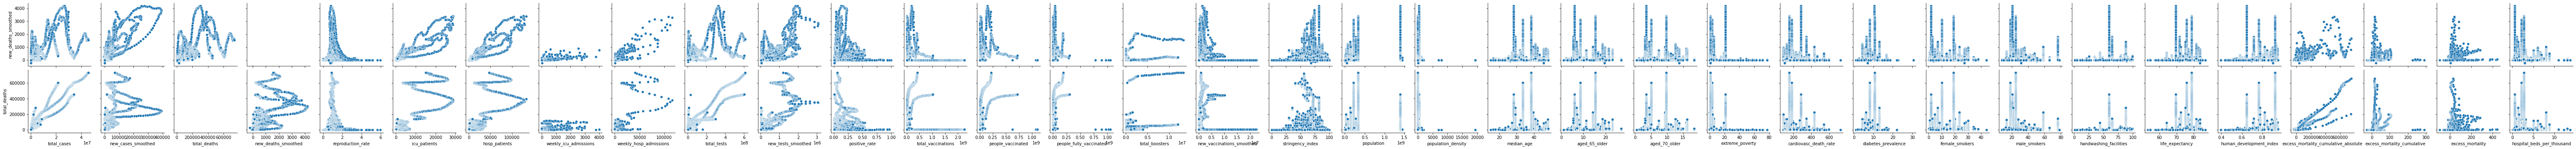

In [6]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], dropna=True)

### Extracting predictor variables & Cleaning up data set

From first glace, our dataset has 2 potential useful dependent variables, "new_deaths_smoothed" and "total_deaths. Looking at the other variables, we can identify that the 2 dependent variables above are paired with "new_cases_smoothed" and "total_cases" respectively. Thus, in our iterations, we would like to use both compare their results.

- **new_deaths_smoothed**
- **total_deaths**

---------------------------------

In the data set, we are also able to locate some of the potential variables as forementioned.
- **new_cases_smoothed / total_cases**
    - This is equivalent to the number of cases and the spread of the virus.
    
- **people_fully_vaccinated_percent**
    - This is equivalent to the vaccination status. This data is created and modified to show the percentage of vaccinated individuals in the country. Here, we make an assumption that each person in the country has the same probability to be vaccinated. This will be calculated using "people_fully_vaccinated" and "population".
    
- **life_expectancy**
    - This is used in place as a health status indicator for the country.
    
- **median_age**
    - This is an indicator of the age of the country.
    
- **hospital_beds_per_thousand**
    - This is an indicator for the healthcare systems that a country has.
    
    
----------------------------------------

Lastly, we are going to remove the rows with NAN data so that we are able to ensure that there are no lapses in the data.

In [7]:
# Create new column called "people_fully_vaccinated_precent"
df = owid_df.copy()
df["people_fully_vaccinated_percent"] = df["people_fully_vaccinated"] / df["population"]

# Listing out the variables that we want to use
columns = ["location", "new_deaths_smoothed", "total_deaths", "new_cases_smoothed", "total_cases",
           "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 

# Extract variables 
df = df[columns]

# Remove NAN rows and reset the index
df = df.dropna().reset_index(drop=True)

# Ensure that data is correct
display(df)

,location,new_deaths_smoothed,total_deaths,new_cases_smoothed,total_cases,people_fully_vaccinated_percent,life_expectancy,median_age,hospital_beds_per_thousand
0,Afghanistan,8.857,2710.0,262.857,62403.0,0.001396,64.83,18.6,0.5
1,Afghanistan,7.286,2772.0,218.571,64575.0,0.001947,64.83,18.6,0.5
2,Afghanistan,9.571,2812.0,382.429,66275.0,0.002433,64.83,18.6,0.5
3,Afghanistan,13.286,2855.0,517.286,67743.0,0.002789,64.83,18.6,0.5
4,Afghanistan,13.857,2869.0,541.571,68366.0,0.002855,64.83,18.6,0.5
...,...,...,...,...,...,...,...,...,...
20382,Zimbabwe,1.000,4662.0,41.286,132540.0,0.167826,61.49,19.6,1.7
20383,Zimbabwe,1.143,4663.0,43.286,132588.0,0.168508,61.49,19.6,1.7
20384,Zimbabwe,0.857,4663.0,36.429,132588.0,0.168970,61.49,19.6,1.7
20385,Zimbabwe,1.571,4669.0,40.429,132651.0,0.169276,61.49,19.6,1.7


------------------------------------

## MLR Iteration 1:

A naive first iteration would be to use all the data points. We can use df_v1 to describe and also understand the data. In our first iteration, we would like to begin with "new_cases_smoothed" and "new_deaths_smoothed" to analyze the relationship between the daily deaths and daily cases.

,new_deaths_smoothed,new_cases_smoothed,people_fully_vaccinated_percent,life_expectancy,median_age,hospital_beds_per_thousand
count,20387.000000,20387.000000,2.038700e+04,20387.000000,20387.000000,20387.000000
mean,114.548745,5958.563425,2.161423e-01,76.923471,35.849796,3.724891
std,334.201760,19883.957302,2.233173e-01,5.249229,7.689226,2.470187
min,-24.571000,-6223.000000,2.300605e-08,53.280000,15.100000,0.100000
25%,2.571000,267.500000,2.675939e-02,74.250000,29.600000,1.900000
50%,14.143000,1052.714000,1.251925e-01,77.290000,37.900000,2.970000
75%,73.000000,3753.000000,3.686437e-01,81.330000,42.700000,5.540000
max,4190.000000,391232.000000,8.681866e-01,84.630000,48.200000,13.050000


Constant: [114.5487122]
new_cases_smoothed: [272.41348636]
people_fully_vaccinated_percent: [-32.14677195]
life_expectancy: [-6.98728215]
median_age: [8.60770773]
hospital_beds_per_thousand: [-6.86311011]


r2: 0.6841325205612063
r2_adj: 0.684039527191401
RMSE: 187.823763824986
Mean: 114.54874469024381
Relative RMSE: 1.6396841740421366


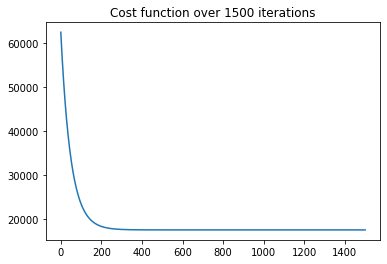

In [8]:
df_v1 = df.copy()

# Define independent and dependent columns
independent_column_v1 = ["new_cases_smoothed", "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 
dependent_column_v1 = ["new_deaths_smoothed"]

# Describe data
display(df_v1[dependent_column_v1 + independent_column_v1].describe())

# Extract dependent & independent variables
df_independent_v1, df_dependent_v1 = get_independents_dependents(df_v1, independent_column_v1, dependent_column_v1)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v1, pred_v1 = linear_regression(df_independent_v1, df_dependent_v1, independent_column_v1, dependent_column_v1)

### Visualizing data & relationship (Iteration 1)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

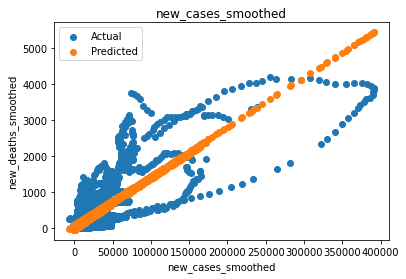

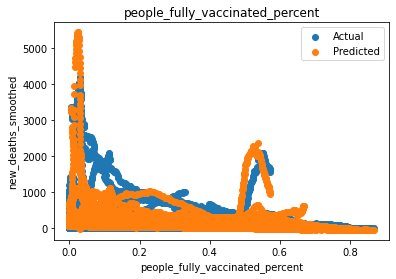

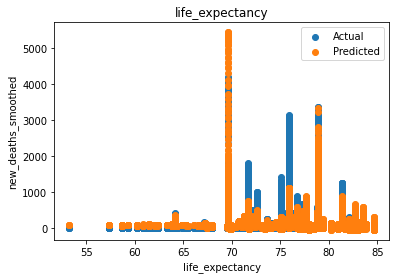

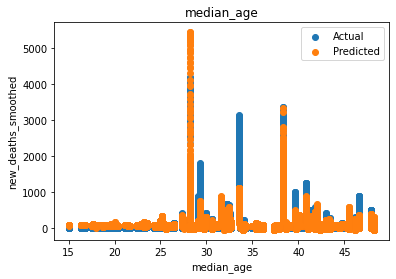

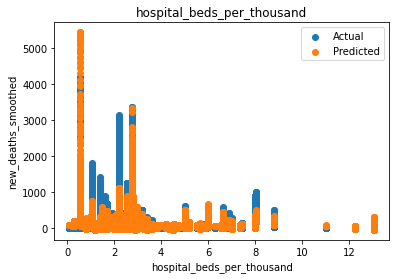

In [9]:
plot_relationship(df_independent_v1, df_dependent_v1, pred_v1, independent_column_v1, dependent_column_v1)

### Discussion of results from iteration 1

Analyzing the data above, visually, we can see that the actual values and predicted values are considerably similar with a high percentage of predicted values matching the actual values. However, from the plotted diagrams, we can see that there are a lot of data points that are concentrated in certain regions of the graph, indicating that there might be a misbalance in the weightage of each country's contribution.

Numerically, there are still improvements to be made as the r2 adjusted values are only 0.68. Furthermore, we can see that relative RMSE is considerably large. This can be explained as when describing the data, we notice that the standard deviation is significantly large as compared to the mean. 

Another numerical value to note is beta. A strongly correlated variable as predicted is "new_cases_smoothed" which has a significant impact on the model generated. Furthermore, by looking at the other coefficients, we can primarily deduce that the variables support the hypothesis forementioned. 

From here, we can move on to iteration 2 and try to improve the model.

------------------------------------

## MLR Iteration 2: 
Looking at the first iteration, we can identify a few issues. For example, some countries may have more data points than others. Therefore, countries with more data points will skew the data and cause it to be unbalanced. Thus, we take the mean for each country, and calculate the expected average death per day. 

,location,new_deaths_smoothed,total_deaths,new_cases_smoothed,total_cases,people_fully_vaccinated_percent,life_expectancy,median_age,hospital_beds_per_thousand
0,Afghanistan,40.554529,3948.882353,983.554588,9.427435e+04,0.004134,64.83,18.6,0.50
1,Albania,3.132907,2486.240310,328.915837,1.426366e+05,0.179307,78.57,38.0,2.89
2,Algeria,25.381333,5374.333333,423.381000,1.969630e+05,0.057959,76.88,29.1,1.90
3,Antigua and Barbuda,0.369929,50.821429,15.043411,1.791500e+03,0.302881,77.02,32.1,3.80
4,Argentina,256.173959,82563.051661,12708.205598,3.764038e+06,0.143742,76.67,31.9,5.00
...,...,...,...,...,...,...,...,...,...
152,Venezuela,15.914300,3672.000000,1221.000000,3.114201e+05,0.093904,72.06,29.0,0.80
153,Vietnam,142.421762,7326.993197,5789.996095,3.177238e+05,0.037264,75.40,32.6,2.60
154,Yemen,4.357000,1506.750000,22.464250,7.844000e+03,0.000697,66.12,20.3,0.70
155,Zambia,18.816341,3044.109890,764.585571,1.824409e+05,0.010157,63.89,17.7,2.00


,new_deaths_smoothed,new_cases_smoothed,people_fully_vaccinated_percent,life_expectancy,median_age,hospital_beds_per_thousand
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,68.998005,3569.765378,0.166062,73.693949,31.482166,2.971217
std,195.227037,10671.236705,0.145558,6.774882,8.833753,2.349782
min,0.000000,0.857000,0.000688,53.280000,15.100000,0.100000
25%,1.891636,119.222333,0.049544,69.870000,25.000000,1.300000
50%,10.869565,654.428082,0.133602,74.990000,31.400000,2.320000
75%,40.042735,2225.664760,0.264821,78.510000,39.600000,4.000000
max,1488.183474,89841.554467,0.739090,84.630000,48.200000,13.050000


Constant: [68.99798505]
new_cases_smoothed: [176.1655994]
people_fully_vaccinated_percent: [-11.64501579]
life_expectancy: [-0.63129551]
median_age: [6.60868486]
hospital_beds_per_thousand: [0.37337458]


r2: 0.8178267313318901
r2_adj: 0.8105398005851657
RMSE: 83.0605421558655
Mean: 68.99800462655935
Relative RMSE: 1.203810785622242


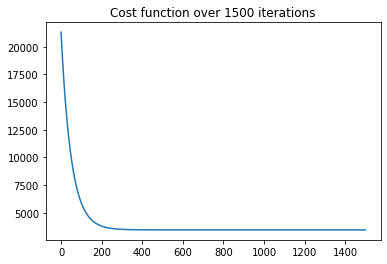

In [10]:
df_v2 = df.copy()
unique_countries = df_v2["location"].unique()
df_mean = pd.DataFrame()

# Obtain the mean for each country such that the data is balanced
for country in unique_countries:
    df_country = df_v2.loc[df_v2["location"] == country, :]
    df_country = df_country.mean(numeric_only=True).to_frame().transpose()
    df_country.insert(0, "location", country)
    df_mean = pd.concat([df_mean, df_country], axis = 0)

df_v2 = df_mean.reset_index(drop=True)

# Ensure that number of countries is still more than 20
unique_countries = df_v2["location"].unique()
assert len(df_v2["location"].unique()) >= 20

# Define variables to be analyzed
independent_column_v2 = ["new_cases_smoothed", "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 
dependent_column_v2 = ["new_deaths_smoothed"]

# Ensure that data is correct
display(df_v2)
display(df_v2[dependent_column_v2 + independent_column_v2].describe())

# Extract dependent & independent variables
df_independent_v2, df_dependent_v2 = get_independents_dependents(df_v2, independent_column_v2, dependent_column_v2)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v2, pred_v2 = linear_regression(df_independent_v2, df_dependent_v2, independent_column_v2, dependent_column_v2)

### Visualizing data & relationship (Iteration 2)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

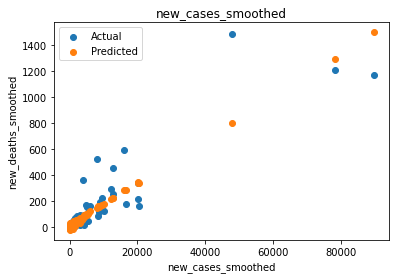

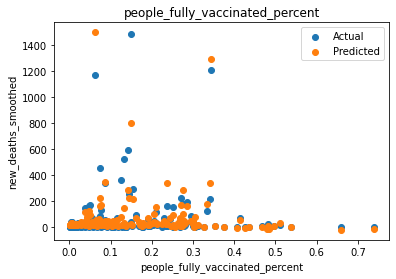

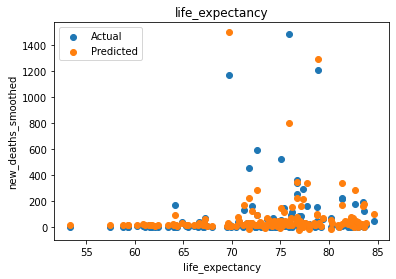

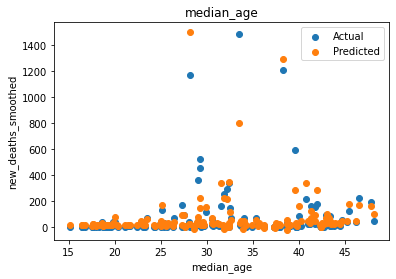

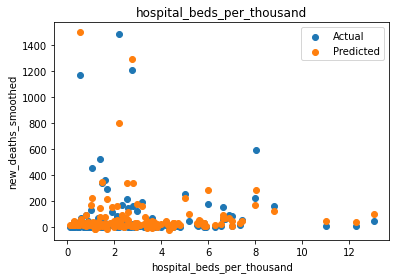

In [11]:
plot_relationship(df_independent_v2, df_dependent_v2, pred_v2, independent_column_v2, dependent_column_v2)

### Discussion of results from iteration 2

Compared to iteration 1, visually, there are no obvious changes to the relationship and the majority of predicted data still aligns with the actual data. However, we can see that the weights of the data is more evenly spreaded out this time which is supported by the lower standard deviation.

Analyzing it numerically, we can see that the r2 adjusted has increased to 0.81, indicating that it is a better fit in the model with a balanced input weight from each country. Additionally, the relative RMSE has also decreased significantly, indicating that this model gives a better prediction as compared to the previous.

However, a thing to note for beta is that the coefficient for "life_expectancy" has a much less significant impact now. This is unexpected as health has been cited in multiple researches to be a big factor in deciding COVID-19 deaths. [[7]](#References) [[8]](#References) One possible explaination for this would be that "life_expectancy" is also an indicator for age, which happens to have a possible correlation with the number of deaths. Furthermore, "life_expectancy" has fluctuated through the pandemic. [[9]](#References) Thus, this indicator might not be good to indicate health.

Another thing to note for beta is that the "hospital_beds_per_thousand" has changed from a negative correlation to a positive one. This is unexpected as better healthcare systems should yield lower deaths. One possible explaination for this would be that a country may increase their hospital beds in order to account for the higher demand in their country. However, as the coefficient is significantly low, we shall use this variable again to verify.

With these considerations in mind, we move onto iteration 3.

------------------------------------

## MLR Iteration 3: 
In the third iteration, we explore the changes when we use tallied data instead of daily data. Another change we would make here would be to exclude "life_expectancy" as it might not be a good indicator for health. Under iteration 3, we would again like to test "hospital_beds_per_thousand" and verify if healthcare systems are a deciding factor in COVID-19 related deaths.

,total_deaths,total_cases,people_fully_vaccinated_percent,hospital_beds_per_thousand,median_age
count,157.000000,1.570000e+02,157.000000,157.000000,157.000000
mean,23909.792227,1.120403e+06,0.166062,2.971217,31.482166
std,70488.242578,3.703401e+06,0.145558,2.349782,8.833753
min,2.320000,1.056694e+03,0.000688,0.100000,15.100000
25%,578.648649,3.081036e+04,0.049544,1.300000,25.000000
50%,3855.868852,2.317867e+05,0.133602,2.320000,31.400000
75%,10814.384342,6.687822e+05,0.264821,4.000000,39.600000
max,587038.678832,3.398244e+07,0.739090,13.050000,48.200000


Constant: [23909.7854448]
total_cases: [65346.1171993]
people_fully_vaccinated_percent: [-2671.83029095]
hospital_beds_per_thousand: [-1854.51430856]
median_age: [4242.4723885]


r2: 0.8696548179977872
r2_adj: 0.8653387523685748
RMSE: 25367.440313022642
Mean: 23909.792226958125
Relative RMSE: 1.0609644815073311


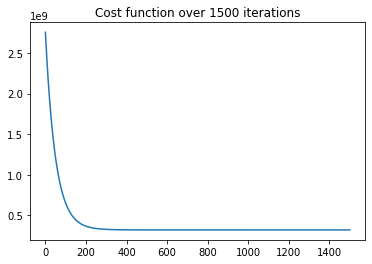

In [12]:
# We can just use df_v2 again as the procedure is the same
df_v3 = df_v2.copy()

# Define variables to be analyzed
independent_column_v3 = ["total_cases", "people_fully_vaccinated_percent", "hospital_beds_per_thousand", "median_age"] 
dependent_column_v3 = ["total_deaths"]

# Describe new data
display(df_v3[dependent_column_v3 + independent_column_v3].describe())

# Extract dependent & independent variables
df_independent_v3, df_dependent_v3 = get_independents_dependents(df_v3, independent_column_v3, dependent_column_v3)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v3, pred_v3 = linear_regression(df_independent_v3, df_dependent_v3, independent_column_v3, dependent_column_v3)

### Visualizing data & relationship (Iteration 3)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

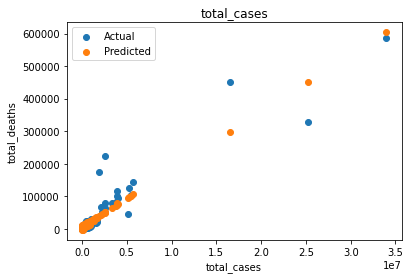

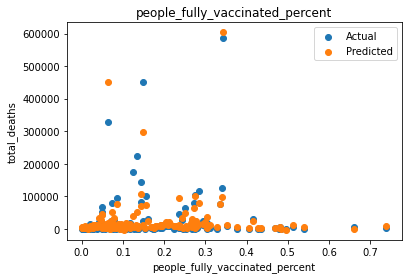

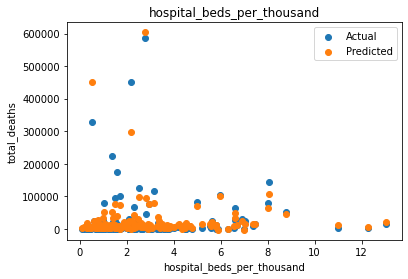

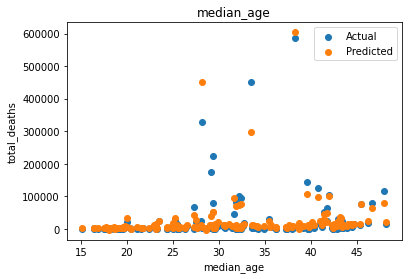

In [13]:
plot_relationship(df_independent_v3, df_dependent_v3, pred_v3, independent_column_v3, dependent_column_v3)

### Discussion of results from iteration 3

Compared to iteration 2, visually, there are no obvious changes to the relationship and the majority of predicted data still aligns with the actual data. However, the spread is still present as there are still some significantly higher number deaths. This is supported by the high standard deviation.

Analyzing it numerically, we can see that the r2 adjusted has increased to 0.87, indicating that there is a better fit in the model with tallied datas computed. Additionally, the relative RMSE has decreased to 1.06, indicating that this model gives a more accurate prediction.

For the coefficients of beta, without "life_expectancy" in consideration, all of the variables support the hypothesis forementioned. 

## Conclusion

In all 3 iterations, we can conclude that the number of COVID-19 related deaths is highly correlated with the number of cases. This is intuitive as a greater spread in virus would mean implication in things such as lower hygiene, more variants, and also a higher amount of people susceptible to COVID-19 deaths.

Additionally, we can also conclude that the percentage of people vaccinated in a country and age of the population also affects their mortality. [[1]](#References) [[2]](#References) This is shown in all 3 models as "people_fully_vaccinated_percent" always has a negative correlation and "median_age" always has a positive correlation. Fropm these correlations, we can deduce that higher vaccination count yields more immunity for the people and also creates herd immunity. [[10]](#References) We can also deduce that as the "median_age" increases, there would be more elderies who have higher mortality rate, thus, making the overall deaths more. 

However, despite the hypothesis, two fluctuating variables "life_expectancy" and "hospital_beds_per_thousand" has considerably lower coefficients and changes their relationship with the number of deaths. Thus, these 2 variables are inconclusive and requires more testing to verify their relationship.

Through these 3 iterations, we have tested various methods of modelling the number of deaths. Overall, if we take a balanced input from each country and the tallied data, we are able to obtain a better prediction. This can be explained by a surplus of data from wealthier countries, thus skewing the data set. Furthermore, daily cases can fluctate and may not be a good indicator for the number of deaths.

------------------------------------

## References

[[1]](#Analyzing-potential-predictor-variables) Cini Oliveira, M., de Araujo Eleuterio, T., de Andrade Corrêa, A.B. et al. Factors associated with death in confirmed cases of COVID-19 in the state of Rio de Janeiro. BMC Infect Dis 21, 687 (2021). https://doi.org/10.1186/s12879-021-06384-1

[[2]](#Analyzing-potential-predictor-variables) Xu S, Huang R, Sy LS, et al. COVID-19 Vaccination and Non–COVID-19 Mortality Risk — Seven Integrated Health Care Organizations, United States, December 14, 2020–July 31, 2021. MMWR Morb Mortal Wkly Rep 2021;70:1520–1524. DOI: http://dx.doi.org/10.15585/mmwr.mm7043e2

[[3]](#Analyzing-potential-predictor-variables) Cifuentes-Faura, J. (2021). Factors influencing the COVID-19 mortality rate in the European Union: importance of medical professionals. Public Health, 200, 1–3. https://doi.org/https://doi.org/10.1016/j.puhe.2021.09.003

[[4]](#Analyzing-potential-predictor-variables) Pasha, D. F., Lundeen, A., Yeasmin, D., &#38; Pasha, M. F. K. (2021). An analysis to identify the important variables for the spread of COVID-19 using numerical techniques and data science. Case Studies in Chemical and Environmental Engineering, 3, 100067. https://doi.org/https://doi.org/10.1016/j.cscee.2020.100067

[[5]](#Finding-and-reading-data-set) Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus'

[[6]](#Preliminary-cleaning-up-of-data-set) FDhir, Rajeev. "How Data Smoothing Works". Investopedia, 2021, https://www.investopedia.com/terms/d/data-smoothing.asp.

[[7]](#Discussion-of-results-from-iteration-2) Williamson, E.J., Walker, A.J., Bhaskaran, K. et al. Factors associated with COVID-19-related death using OpenSAFELY. Nature 584, 430–436 (2020). https://doi.org/10.1038/s41586-020-2521-4

[[8]](#Discussion-of-results-from-iteration-2) Upadhyaya, A., Koirala, S., Ressler, R. and Upadhyaya, K. (2020), "Factors affecting COVID-19 mortality: an exploratory study", Journal of Health Research, Vol. ahead-of-print No. ahead-of-print. https://doi.org/10.1108/JHR-09-2020-0448

[[9]](#Discussion-of-results-from-iteration-2) José Manuel Aburto, Jonas Schöley, Ilya Kashnitsky, Luyin Zhang, Charles Rahal, Trifon I Missov, Melinda C Mills, Jennifer B Dowd, Ridhi Kashyap, Quantifying impacts of the COVID-19 pandemic through life-expectancy losses: a population-level study of 29 countries, International Journal of Epidemiology, 2021;, dyab207, https://doi.org/10.1093/ije/dyab207

[[10]](#Conclusion) "Herd Immunity And COVID-19 (Coronavirus): What You Need To Know". Mayo Clinic, 2021, https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/herd-immunity-and-coronavirus/art-20486808.

## **Task 2**: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.
The following technical/tool constraint applies: you are NOT allowed to use Neural Networks or other Machine Learning models. You must use Python and Jupyter Notebook.
In general, you may want to consider performing the following steps:
- Find an interesting problem which you want to solve either using Linear Regression or
Classification (please check with your instructors first on whether the problem makes
sense).
- Find a dataset to build your model. For example, you can use Kaggle
(https://www.kaggle.com/datasets) to find suitable datasets.
- Use plots to visualize and understand your data.
- Create training and test data sets.
- Build your model.
- Choose an appropriate metric to evaluate your model (you may use the same metric as
the one used in Task 1).
- Improve your model.

# Problem Statement
Singapore's increasing COVID-19 cases of between 2,000 to 5,000 over the past month have placed significant strain on our healthcare system. Bed occupancy rates at hospitals have surged and healthcare workers are facing pressure like never before. Singapore now provides around 2,500 beds for COVID-19 patients, up from 900 previously. As of now, Singapore is shifting the majority of COVID-19 patients towards home recovery as the default care arrangement to ease the load on the healthcare system. However, reducing the strain on the healthcare system does not imply that the workload of the healthcare workers has been reduced. Therefore, to allow our healthcare workers to better prepare for the upcoming challenges by improving the allocation of medical resources, __I aim to produce a multiple linear regression model which will be able to give accurate predictions for the number of people who will still be hospitalised given specific data in Singapore__.
>Dataset - https://www.kaggle.com/shivamb/covid19-in-singapore-latest-detailed-data/tasks

In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data
The data used are provided by the Ministry of Health (MOH) Singapore relating to COVID-19 from __2020-10-23__ to __2021-11-10__.

In [15]:
df = pd.read_csv("covid19_sg.csv")

In [16]:
# List of features in the dataset.
list(df.columns)

['Date',
 'Daily Confirmed',
 'False Positives Found',
 'Cumulative Confirmed',
 'Daily Discharged',
 'Passed but not due to COVID',
 'Cumulative Discharged',
 'Discharged to Isolation',
 'Still Hospitalised',
 'Daily Deaths',
 'Cumulative Deaths',
 'Tested positive demise',
 'Daily Imported',
 'Daily Local transmission',
 'Local cases residing in dorms MOH report',
 'Local cases not residing in doms MOH report',
 'Intensive Care Unit (ICU)',
 'General Wards MOH report',
 'In Isolation MOH report',
 'Total Completed Isolation MOH report',
 'Total Hospital Discharged MOH report',
 'Requires Oxygen Supplementation',
 'Linked community cases',
 'Unlinked community cases',
 'Phase',
 'Cumulative Vaccine Doses',
 'Cumulative Individuals Vaccinated',
 'Cumulative Individuals Vaccination Completed',
 'Perc population completed at least one dose',
 'Perc population completed vaccination',
 'Sinovac vaccine doses',
 'Cumulative individuals using Sinovac vaccine',
 'Doses of other vaccines recog

In [17]:
# First 5 rows of the dataset.
df.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination,Sinovac vaccine doses,Cumulative individuals using Sinovac vaccine,Doses of other vaccines recognised by WHO,Cumulative individuals using other vaccines recognised by WHO,Number taken booster shots,Perc population taken booster shots
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Statistics of all the features in the dataset.
df.describe()

,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,...,Linked community cases,Unlinked community cases,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Sinovac vaccine doses,Cumulative individuals using Sinovac vaccine,Doses of other vaccines recognised by WHO,Cumulative individuals using other vaccines recognised by WHO,Number taken booster shots
count,658.000000,549.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,...,160.000000,160.000000,1.200000e+02,1.200000e+02,1.200000e+02,9.000000,9.000000,80.000000,80.000000,31.000000
mean,346.141337,0.145719,55442.781155,304.887538,0.009119,51267.972644,3792.004559,332.548632,0.822188,43.767477,...,30.450000,14.618750,8.295745e+06,4.392539e+06,3.879330e+06,118138.222222,78083.444444,180066.400000,92550.212500,478587.129032
std,809.413319,2.299771,36697.626658,752.472549,0.095127,33090.209386,7132.993306,551.177584,2.830632,73.624323,...,38.199707,26.721454,1.192874e+06,2.882246e+05,8.200380e+05,10618.138923,3019.922603,38125.334479,18985.378822,180971.682669
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-16.000000,0.000000,0.000000,...,0.000000,0.000000,5.485548e+06,3.376297e+06,2.109251e+06,104061.000000,74121.000000,42623.000000,24130.000000,172090.000000
25%,12.000000,0.000000,44845.750000,11.000000,0.000000,40530.000000,91.500000,14.000000,0.000000,26.000000,...,2.000000,1.000000,7.485895e+06,4.297320e+06,3.310855e+06,108815.000000,75856.000000,162833.500000,85373.750000,331327.500000
50%,33.000000,0.000000,58365.000000,25.500000,0.000000,58267.000000,254.500000,89.000000,0.000000,29.000000,...,12.000000,3.500000,8.689759e+06,4.506378e+06,4.306486e+06,115970.000000,77095.000000,179602.000000,86772.000000,487673.000000
75%,217.250000,0.000000,62021.750000,200.750000,0.000000,61453.250000,3694.000000,393.250000,0.000000,32.750000,...,49.750000,17.000000,9.135696e+06,4.593508e+06,4.480897e+06,129787.000000,81555.000000,203645.750000,106014.750000,629889.000000
max,5324.000000,41.000000,227681.000000,5087.000000,1.000000,200616.000000,31166.000000,4229.000000,18.000000,540.000000,...,156.000000,185.000000,1.004902e+07,4.734669e+06,4.675888e+06,131497.000000,81709.000000,239146.000000,122126.000000,760408.000000


## Visualization of Dataset
Allows us to better understand the data we are dealing with and do appropriate analysis to decide which features to use.

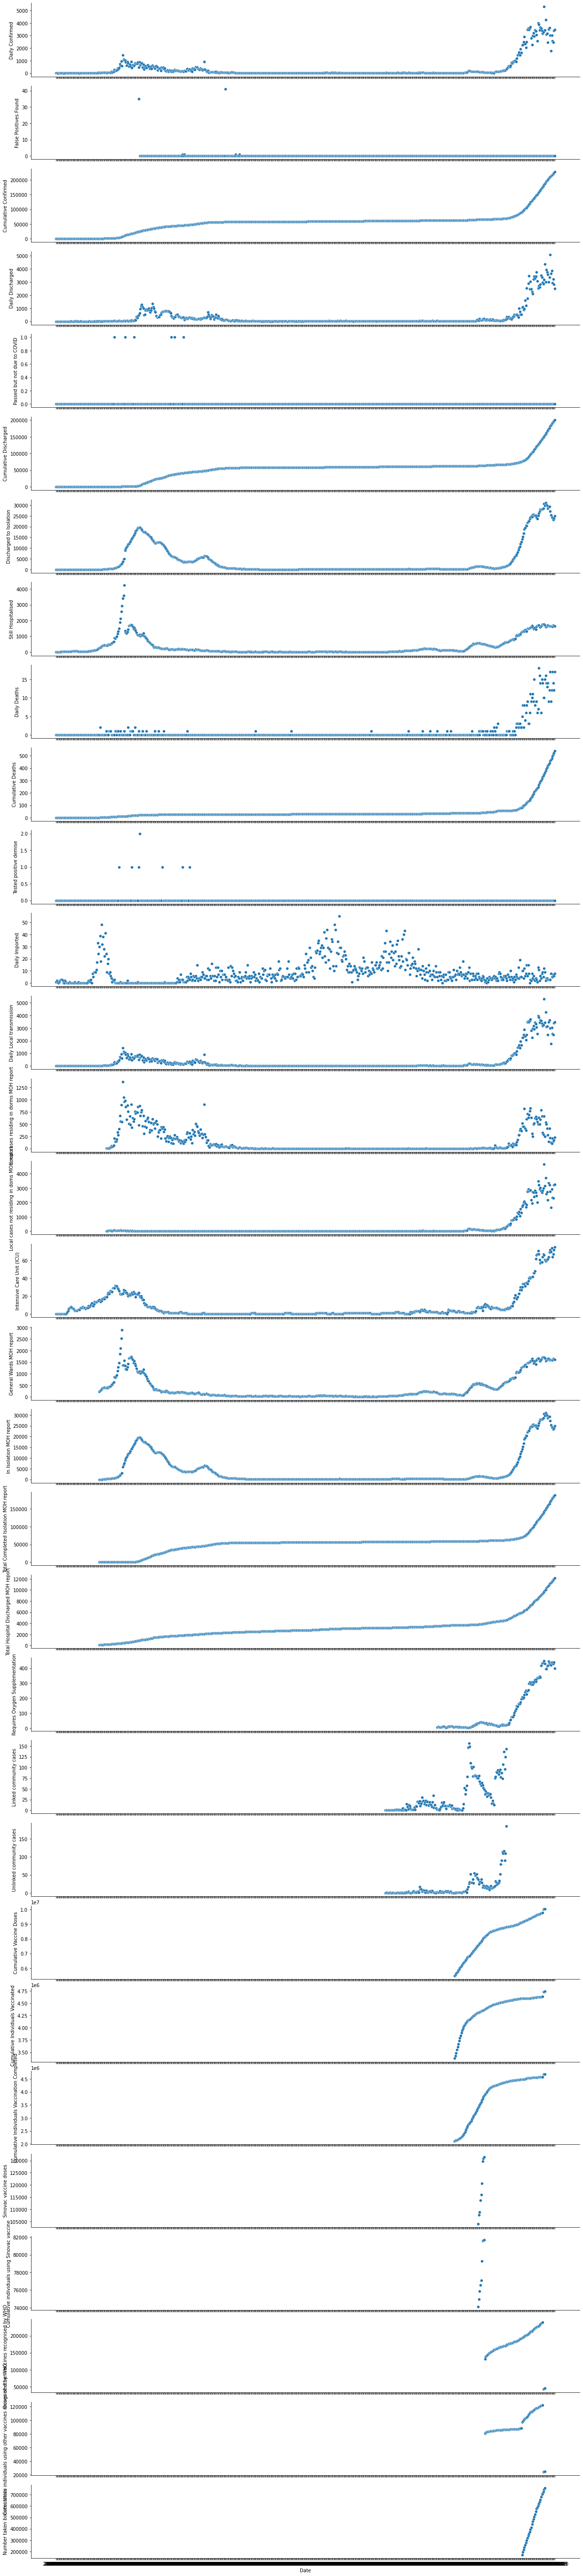

In [19]:
# Plotting all the features with respect to Date.
myplot = sns.pairplot(df, x_vars=["Date"], aspect=7)

## Features and Target selection
- After analyzing all the data with respect to the date, we have decided to use 3 features which are "Daily Confirmed", "Daily Discharged" and "Discharged to Isolation" to predict our target "Still Hospitalised".
- We settled down on these 3 features because we feel that it contributes the most to the number of people still hospitalized.
- We have also decided to use the data which only falls under the category of "Preparatory Stage" or "Stabilisation Phase" under the "Phase" column to reduce the noise of the dataset to give us a more accurate prediction after training the model.

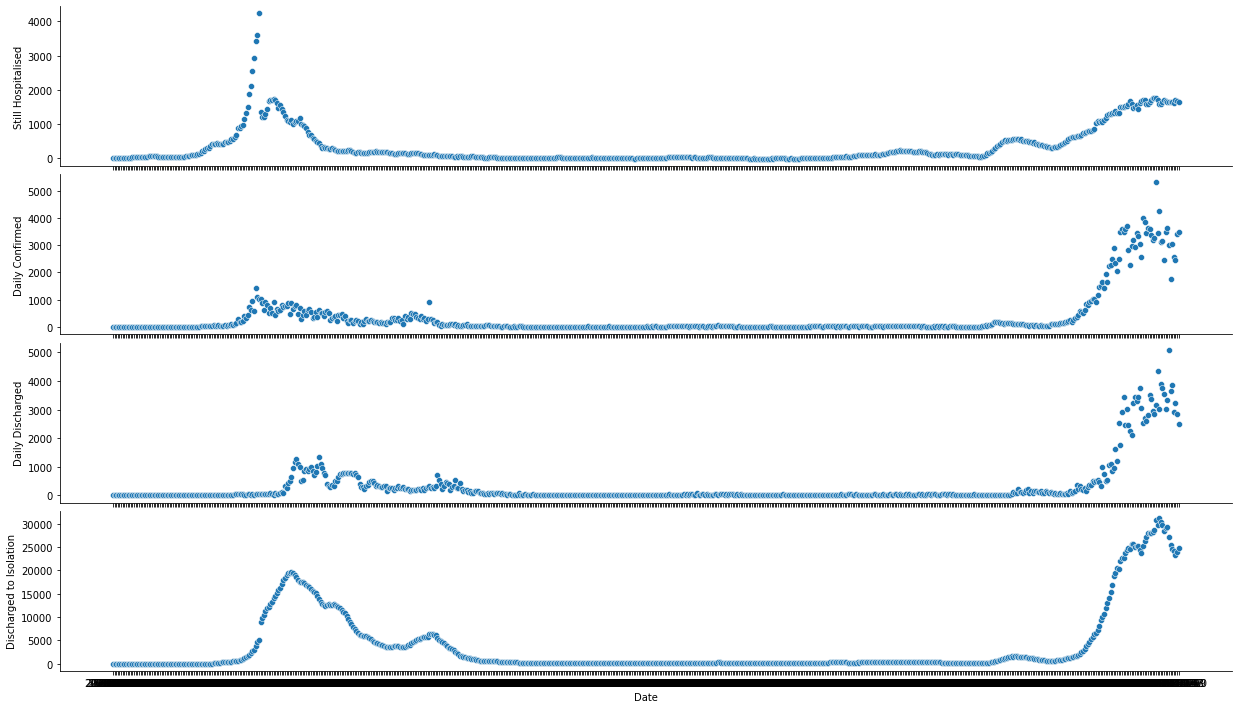

In [20]:
# Plotting interested features with respect to date to get a better understanding of the data we are dealing with.
myplot = sns.pairplot(df, x_vars=["Date"], y_vars=["Still Hospitalised", "Daily Confirmed", "Daily Discharged", "Discharged to Isolation"], aspect=7)

In [21]:
# Choosing only the rows that are in the "Preparatory Stage" or "Stabilisation Phase" in the "Phase" column.
df = df.loc[(df["Phase"] == "Preparatory Stage") | (df["Phase"] == "Stabilisation Phase"), :]

In [22]:
# Statistics of the updated dataframe we are working with.
df.describe()

,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,...,Linked community cases,Unlinked community cases,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Sinovac vaccine doses,Cumulative individuals using Sinovac vaccine,Doses of other vaccines recognised by WHO,Cumulative individuals using other vaccines recognised by WHO,Number taken booster shots
count,93.000000,93.0,93.000000,93.000000,93.0,93.000000,93.000000,93.000000,93.000000,93.000000,...,29.000000,29.000000,8.000000e+01,8.000000e+01,8.000000e+01,0.0,0.0,80.000000,80.000000,31.000000
mean,1740.268817,0.0,112449.182796,1468.086022,0.0,97850.655914,13361.731183,1067.623656,5.365591,161.172043,...,66.965517,46.034483,9.029179e+06,4.553975e+06,4.401844e+06,NaN,NaN,180066.400000,92550.212500,478587.129032
std,1458.017289,0.0,52548.092161,1465.045508,0.0,41888.061711,11596.410651,527.749980,5.694744,147.620520,...,37.192052,45.014666,4.660310e+05,7.544479e+04,1.705505e+05,NaN,NaN,38125.334479,18985.378822,180971.682669
min,32.000000,0.0,65890.000000,40.000000,0.0,64174.000000,482.000000,306.000000,0.000000,42.000000,...,12.000000,9.000000,8.145237e+06,4.373550e+06,3.897650e+06,NaN,NaN,42623.000000,24130.000000,172090.000000
25%,191.000000,0.0,67991.000000,141.000000,0.0,66334.000000,1188.000000,498.000000,0.000000,55.000000,...,38.000000,16.000000,8.692396e+06,4.507032e+06,4.308232e+06,NaN,NaN,162833.500000,85373.750000,331327.500000
50%,1647.000000,0.0,85953.000000,541.000000,0.0,74157.000000,10600.000000,1112.000000,3.000000,76.000000,...,75.000000,24.000000,8.933048e+06,4.573230e+06,4.446981e+06,NaN,NaN,179602.000000,86772.000000,487673.000000
75%,3163.000000,0.0,150731.000000,2926.000000,0.0,125058.000000,24861.000000,1589.000000,9.000000,239.000000,...,90.000000,79.000000,9.381584e+06,4.597582e+06,4.535758e+06,NaN,NaN,203645.750000,106014.750000,629889.000000
max,5324.000000,0.0,227681.000000,5087.000000,0.0,200616.000000,31166.000000,1757.000000,18.000000,540.000000,...,143.000000,185.000000,1.004902e+07,4.734669e+06,4.675888e+06,NaN,NaN,239146.000000,122126.000000,760408.000000


In [23]:
# Making sure that we are only left with the rows that falls under the category of "Preparatory Stage" or "Stabilisation Phase".
df["Phase"].unique()

array(['Preparatory Stage', 'Stabilisation Phase'], dtype=object)

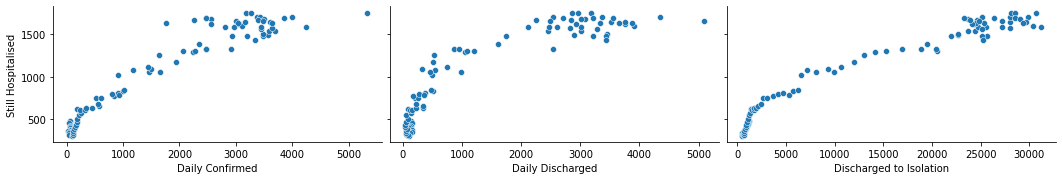

In [24]:
# Plotting the target against the 3 features that we will be using to make prediction.
myplot = sns.pairplot(df, x_vars=["Daily Confirmed", "Daily Discharged", "Discharged to Isolation"], y_vars=["Still Hospitalised"], aspect=2)

## Setting up data for training/ Feature Scaling
- Feature scaling is essential for machine learning algorithms that calculate distances between data. If not scaled, the feature with a higher value range starts dominating when calculating distances. For example, if we don't scale our features, with the difference in range of maybe "Daily Confirmed" which roughly ranges from 0-5,000, and "Discharged to Isolation" which roughly ranges from 0-30,000, the model may make the underlying assumption that higher ranging numbers have superiority of some sort which may not be entirely true and the higher range values may play a more decisive role when training the model.
- Feature scaling brings every feature in the same footing without any upfront importance. In addition, feature scaling also allows gradient descent to converge more quickly.

> Standardization
$$normalized = \frac{data - \mu}{\sigma}$$

In [25]:
# Setting up features and target.
features = ["Daily Confirmed",
            "Daily Discharged",
            "Discharged to Isolation"]

target = "Still Hospitalised"

X = df.loc[:, features]
y = df.loc[:, target]

In [26]:
# Statistics of features.
X.describe()

,Daily Confirmed,Daily Discharged,Discharged to Isolation
count,93.000000,93.000000,93.000000
mean,1740.268817,1468.086022,13361.731183
std,1458.017289,1465.045508,11596.410651
min,32.000000,40.000000,482.000000
25%,191.000000,141.000000,1188.000000
50%,1647.000000,541.000000,10600.000000
75%,3163.000000,2926.000000,24861.000000
max,5324.000000,5087.000000,31166.000000


In [27]:
# Statistics of target.
y.describe()

count      93.000000
mean     1067.623656
std       527.749980
min       306.000000
25%       498.000000
50%      1112.000000
75%      1589.000000
max      1757.000000
Name: Still Hospitalised, dtype: float64

In [28]:
# Standardization function.
def normalize_z(array):
    dfout = (array - array.mean(axis=0)) / array.std(axis=0)
    return dfout

In [29]:
# Train test split data function.
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    total_samples = len(df_feature)
    test_size = int(test_size * total_samples)
    
    rng = np.random.RandomState(random_state)
    order = rng.choice(total_samples, total_samples, replace=False)
    
    df_feature_train = df_feature.iloc[order[test_size:], :]
    df_feature_test = df_feature.iloc[order[:test_size], :]
    df_target_train = df_target.iloc[order[test_size:]]
    df_target_test = df_target.iloc[order[:test_size]]
    
    return np.array(df_feature_train), np.array(df_feature_test), np.array(df_target_train), np.array(df_target_test)

In [30]:
# Splitting data with a test size of 20% and random state = 100.
X_train, X_test, y_train, y_test = split_data(X, y, random_state=100, test_size=0.2)

In [31]:
# Normalizing training data before training.
X_train = normalize_z(X_train)

## Building linear regression model
- Linear regression is a linear model, e.g. a model that assumes a linear relationship between the features (x) and the target (y). More specifically, that y can be calculated from a linear combination of the features (x).
$$y = \beta_0 + \beta_1 x$$

- For this specific task, we will be using a multiple linear regression where we have 3 features and 1 target.
$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \hat{\beta}_3 x_3$$

- The cost function that we will be using is:
$$J(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3) = \frac{1}{2m}(\mathbf{\hat{y}}-\mathbf{y})^T\times (\mathbf{\hat{y}}-\mathbf{y})$$

- And using gradient descent, we will be updating the weights and bias on every iteration using this function:
$$\mathbf{\hat{b}} = \mathbf{\hat{b}} - \alpha \frac{1}{m}\mathbf{X}^T \times (\mathbf{\hat{y}} - \mathbf{y})$$

- The metrics we will be using to evaluate our model:
    - Mean Squared Error
    $$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$
    - Root Mean Squared Error
    $$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2}$$
    - R2 Coefficient of Determination
    $$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

In [32]:
class LinearRegressionModel:
    def __init__(self, lr=0.01, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.J_storage = np.array([])

    def fit(self, x, y):
        """Trains the model for a fixed number of epochs"""
        n_samples, n_features = x.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.epochs):
            # Calculating y predicted
            y_pred = np.dot(x, self.weights) + self.bias
            
            # Calculating Cost and storing it
            self.J_storage = np.append(self.J_storage, (1 / (2 * n_samples)) * np.matmul((y_pred - y).T, (y_pred - y)))
            
            # Calculating the gradient for weights and bias
            weights_grad = (1/ n_samples) * np.dot(x.T, (y_pred - y))
            bias_grad = (1/ n_samples) * np.sum(y_pred - y)
            
            # Making the gradient descent step
            self.weights -= self.lr * weights_grad
            self.bias -= self.lr * bias_grad
        
    def predict(self, x):
        """Generates output predictions for the input samples"""
        x = normalize_z(x)
        y_pred = np.dot(x, self.weights) + self.bias
        return y_pred
    
    def r_squared(self, y_true, y_pred):
        """R-squared"""
        ss_res = ((y_true-y_pred)**2).sum()
        ss_tot = ((y_true-y_true.mean())**2).sum()
        return 1 - (ss_res/ss_tot)

    def mse(self, y_true, y_pred):
        """Mean Squared Error"""
        return np.mean((y_true - y_pred) ** 2)
    
    def rmse(self, y_true, y_pred):
        """Mean Squared Error"""
        return (np.mean((y_true - y_pred) ** 2)) ** 0.5

## Training Model

In [33]:
# Training model with learning rate of 0.01 and 100,000 iterations.
regressor = LinearRegressionModel(lr=0.01, epochs=100000)
regressor.fit(X_train, y_train)

Text(0, 0.5, 'Cost')

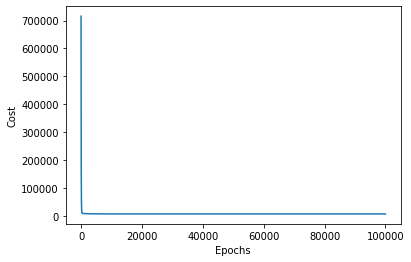

In [34]:
# Plotting cost against iterations.
plt.plot(regressor.J_storage)
plt.xlabel("Epochs")
plt.ylabel("Cost")

In [35]:
regressor.weights

array([ 68.47531586, -75.57201147, 520.71724618])

In [36]:
regressor.bias

1072.0266666666555

## Model Prediction

In [37]:
# Making predictions.
predictions = regressor.predict(X_test)
predictions

array([1844.17125234, 1732.33690636,  579.32462029,  585.66805813,
        936.80755382, 1576.62119937,  714.9643183 , 1001.35340117,
        565.75049005, 1535.89934923,  548.91275962,  639.01944274,
        529.65278643, 1609.84400136,  597.4718254 , 1791.92432041,
        731.12518123, 1775.63253376])

In [38]:
y_test

array([1757, 1589,  623,  634, 1053, 1490,  779, 1090,  469, 1695,  413,
        678,  334, 1482,  613, 1708,  792, 1688])

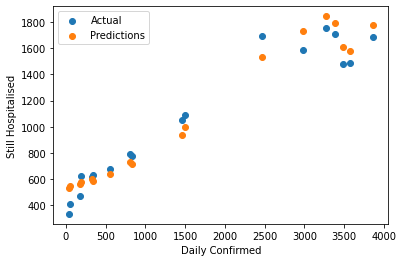

In [39]:
plt.scatter(X_test[:, 0], y_test, label="Actual")
plt.scatter(X_test[:, 0], predictions, label="Predictions")
plt.xlabel("Daily Confirmed")
plt.ylabel("Still Hospitalised")
plt.legend()

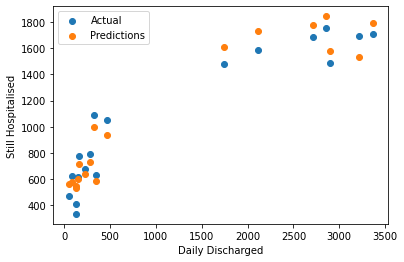

In [40]:
plt.scatter(X_test[:, 1], y_test, label="Actual")
plt.scatter(X_test[:, 1], predictions, label="Predictions")
plt.xlabel("Daily Discharged")
plt.ylabel("Still Hospitalised")
plt.legend()

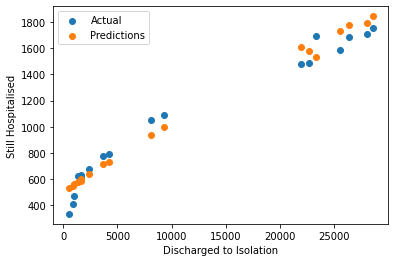

In [41]:
plt.scatter(X_test[:, 2], y_test, label="Actual")
plt.scatter(X_test[:, 2], predictions, label="Predictions")
plt.xlabel("Discharged to Isolation")
plt.ylabel("Still Hospitalised")
plt.legend()

## Evaluating Model
- __R-squared__ evaluates the scatter of the data points around the fitted regression line. It indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. In general, the higher the r-squared, the better the model fits the data.
- __Mean Squared Error__ is a measure of how close a fitted line is to data points. The smaller the mean squared error, the closer the fit is to the data.
- __Root Mean Squared Error__ is just the square root of the mean square error. It is the distance, on average, of a data point from the fitted line, measured along a vertical line.

In [42]:
print(f"R^2: {regressor.r_squared(y_test, predictions)}")

R^2: 0.9571276164453675


In [43]:
print(f"MSE: {regressor.mse(y_test, predictions)}")

MSE: 10739.426355020438


In [44]:
print(f"RMSE: {regressor.rmse(y_test, predictions)}")

RMSE: 103.63120357797857


# Multiple Linear Regression Model with Logarithmic Transformation
- After further analysis of the data, we realized that we might be able to get better results if we modeled it using a logarithmic function. The shape of the data looks closely related to that of a logarithm graph.
- In this model, the features are log-transformed but the target remains the same.

Text(0.5, 1.0, 'Logarithm Graph')

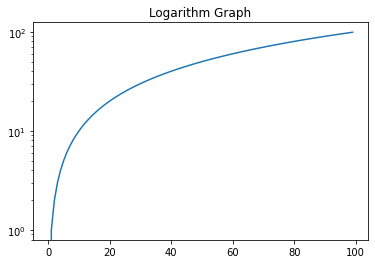

In [45]:
# Plotting a logarithm graph.
plt.plot(list(range(100)))
plt.yscale("log")
plt.title("Logarithm Graph")

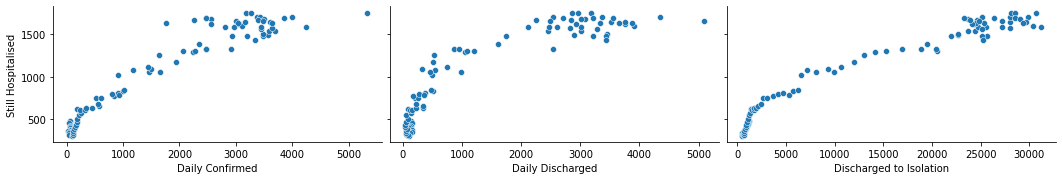

In [46]:
# Plotting the target against the 3 features used for the linear model above.
myplot = sns.pairplot(df, x_vars=["Daily Confirmed", "Daily Discharged", "Discharged to Isolation"], y_vars=["Still Hospitalised"], aspect=2)

In [47]:
X

,Daily Confirmed,Daily Discharged,Discharged to Isolation
565,54,90,1188
566,63,141,1109
567,59,87,1119
568,49,157,992
569,58,132,955
...,...,...,...
653,3035,3871,24511
654,2553,2926,24133
655,2470,3216,23302
656,3397,2834,23878


In [48]:
y

565     478
566     478
567     440
568     458
569     421
       ... 
653    1636
654    1624
655    1695
656    1670
657    1656
Name: Still Hospitalised, Length: 93, dtype: int64

## Transforming data through a logarithmic function

In [49]:
# Feature transform function.
def transform_features(X):
    X_log = X.copy()
    for feature in X.columns:
        X_log[feature] = X[feature].apply(lambda x: np.log(x))
    return X_log

In [50]:
X_log = transform_features(X)

In [51]:
X_log

,Daily Confirmed,Daily Discharged,Discharged to Isolation
565,3.988984,4.499810,7.080026
566,4.143135,4.948760,7.011214
567,4.077537,4.465908,7.020191
568,3.891820,5.056246,6.899723
569,4.060443,4.882802,6.861711
...,...,...,...
653,8.017967,8.261268,10.106877
654,7.845024,7.981392,10.091335
655,7.811973,8.075894,10.056294
656,8.130648,7.949444,10.080713


In [52]:
# Statistics of transformed features.
X_log.describe()

,Daily Confirmed,Daily Discharged,Discharged to Isolation
count,93.000000,93.000000,93.000000
mean,6.683475,6.407736,8.717936
std,1.587599,1.557785,1.516425
min,3.465736,3.688879,6.177944
25%,5.252273,4.948760,7.080026
50%,7.406711,6.293419,9.268609
75%,8.059276,7.981392,10.121056
max,8.579980,8.534444,10.347083


## Visualizing logarithmic data

Text(0, 0.5, 'Still Hospitalised')

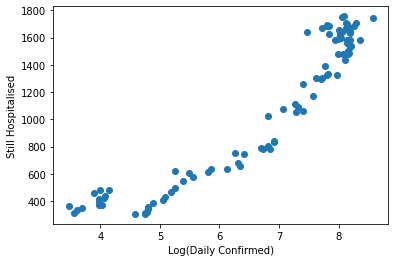

In [53]:
plt.scatter(X_log["Daily Confirmed"], y)
plt.xlabel("Log(Daily Confirmed)")
plt.ylabel("Still Hospitalised")

Text(0, 0.5, 'Still Hospitalised')

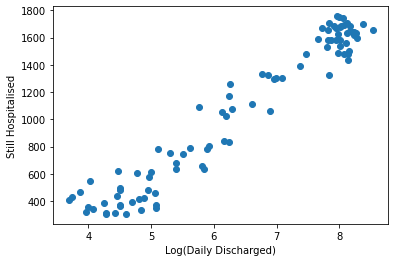

In [54]:
plt.scatter(X_log["Daily Discharged"], y)
plt.xlabel("Log(Daily Discharged)")
plt.ylabel("Still Hospitalised")

Text(0, 0.5, 'Still Hospitalised')

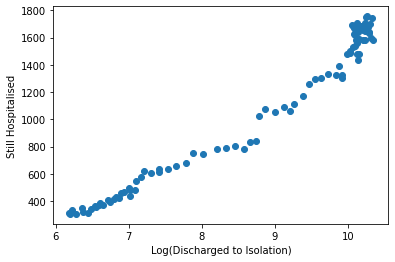

In [55]:
plt.scatter(X_log["Discharged to Isolation"], y)
plt.xlabel("Log(Discharged to Isolation)")
plt.ylabel("Still Hospitalised")

## Setting up data for training

In [56]:
X_log_train, X_log_test, y_log_train, y_log_test = split_data(X_log, y, random_state=100, test_size=0.2)

In [57]:
X_log_train = normalize_z(X_log_train)

## Training Model

In [58]:
# Training model with learning rate of 0.01 and 100,000 iterations.
regressor_log = LinearRegressionModel(lr=0.01, epochs=100000)
regressor_log.fit(X_log_train, y_log_train)

Text(0, 0.5, 'Cost')

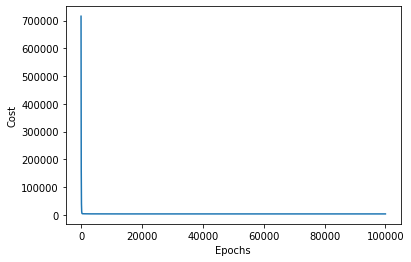

In [59]:
# Plotting cost against iterations.
plt.plot(regressor_log.J_storage)
plt.xlabel("Epochs")
plt.ylabel("Cost")

In [60]:
regressor_log.weights

array([-16.24293005, 163.9988704 , 378.94902393])

In [61]:
regressor_log.bias

1072.0266666666555

## Model predictions

In [62]:
# Making predictions.
predictions_log = regressor_log.predict(X_log_test)
predictions_log

array([1704.73502938, 1640.13255539,  495.4254671 ,  701.46239021,
       1157.13366867, 1641.33013865,  825.62506144, 1150.91112851,
        349.56587645, 1665.70096418,  434.57258147,  749.21707721,
        284.13167458, 1574.66285896,  607.09341283, 1717.96485005,
        922.2669969 , 1674.54826803])

In [63]:
y_log_test

array([1757, 1589,  623,  634, 1053, 1490,  779, 1090,  469, 1695,  413,
        678,  334, 1482,  613, 1708,  792, 1688])

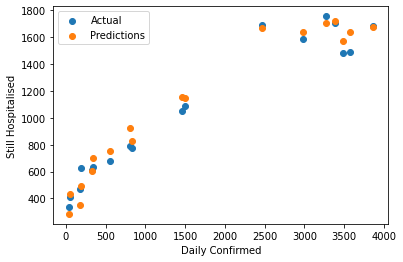

In [64]:
plt.scatter(X_test[:, 0], y_log_test, label="Actual")
plt.scatter(X_test[:, 0], predictions_log, label="Predictions")
plt.xlabel("Daily Confirmed")
plt.ylabel("Still Hospitalised")
plt.legend()

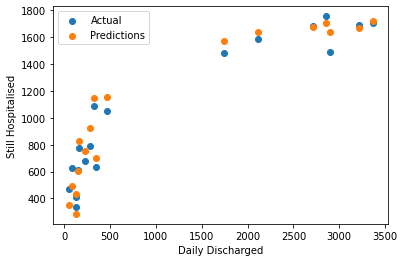

In [65]:
plt.scatter(X_test[:, 1], y_log_test, label="Actual")
plt.scatter(X_test[:, 1], predictions_log, label="Predictions")
plt.xlabel("Daily Discharged")
plt.ylabel("Still Hospitalised")
plt.legend()

In [ ]:
plt.scatter(X_test[:, 2], y_log_test, label="Actual")
plt.scatter(X_test[:, 2], predictions_log, label="Predictions")
plt.xlabel("Discharged to Isolation")
plt.ylabel("Still Hospitalised")
plt.legend()

## Evaluating Model

In [ ]:
print(f"R^2: {regressor_log.r_squared(y_log_test, predictions_log)}")

In [ ]:
print(f"MSE: {regressor_log.mse(y_log_test, predictions_log)}")

In [ ]:
print(f"RMSE: {regressor_log.rmse(y_log_test, predictions_log)}")

# Conclusion

### Multiple Linear Regression Model
>R^2 = 0.9571276164453675 

>MSE = 10739.426355020438 

>RMSE = 103.63120357797857

### Multiple Linear Regression Model with Logarithmic Transformation
>R^2 = 0.9745352633337527 

>MSE = 6378.8537375968035

>RMSE = 79.86772650825115

- We are able to get better r^2, mse, and rmse value with the model with logarithmic transformation compared to the usual model with the same train and test set.
- From the results, we are able to conclude that with the dataset we are working with, linear regression is able to give us better results when we apply a logarithmic transformation to the features and we are able to get quite an accurate prediction for the number of people still hospitalised.

In [ ]:
plt.scatter(X_test[:, 0], y_log_test, label="Actual")
plt.scatter(X_test[:, 0], predictions, label="Predictions")
plt.scatter(X_test[:, 0], predictions_log, label="Predictions_log")
plt.xlabel("Daily Confirmed")
plt.ylabel("Still Hospitalised")
plt.legend()

In [ ]:
plt.scatter(X_test[:, 1], y_log_test, label="Actual")
plt.scatter(X_test[:, 1], predictions, label="Predictions")
plt.scatter(X_test[:, 1], predictions_log, label="Predictions_log")
plt.xlabel("Daily Discharged")
plt.ylabel("Still Hospitalised")
plt.legend()

In [ ]:
plt.scatter(X_test[:, 2], y_log_test, label="Actual")
plt.scatter(X_test[:, 2], predictions, label="Predictions")
plt.scatter(X_test[:, 2], predictions_log, label="Predictions_log")
plt.xlabel("Discharged to Isolation")
plt.ylabel("Still Hospitalised")
plt.legend()

## Video Link
https://youtu.be/U-eDmILcFUY